<a href="https://colab.research.google.com/github/oraziotorre/TTinsight/blob/main/TTinsight_ModelDevelopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTinsight


---


## Model Development
In questo notebook vedremo tutto il processo di allenamento e testing del modello Logistic Regression e del modello LSTM

## **Inizializzazione**

In [34]:
# Gestione dei dati
import pandas as pd
import numpy as np
import os
import joblib
import ast
from collections import defaultdict
import math
import glob
import shutil

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning e metriche
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,brier_score_loss, log_loss
from sklearn.preprocessing import StandardScaler


# Deep Learning con Keras e TensorFlow
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, concatenate
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences

In [2]:
# Importiamo il dataset ottenuto tramite le operazioni di Data Preprocessing
dataset = pd.read_csv("cleaned_dataset.csv")

dataset

,final_set_a,final_set_b,points_progression,score_a,score_b,comeback,half_diff,third_diff,length,set_result
0,0,0,"[0, 0, 1, 1, 0, 1, 1]",4,3,0.500000,2,2,7,0
1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0]",4,4,-0.250000,0,1,8,0
2,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0]",4,5,-0.400000,-1,-2,9,0
3,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1]",5,5,0.200000,1,-1,10,0
4,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1]",6,5,0.333333,2,0,11,0
...,...,...,...,...,...,...,...,...,...,...
489295,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0]",3,6,-0.833333,-5,-2,9,0
489296,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]",4,7,0.250000,-4,-2,11,0
489297,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]",5,7,0.400000,-2,1,12,0
489298,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]",5,8,-0.125000,-3,0,13,0


## **Train-Test split**

Per ridurre il rischio di data leakage, abbiamo progettato un processo di training-test split che include diversi accorgimenti mirati:

- **Distribuzione delle tipologie di punteggi**: Assicuriamo che le stesse percentuali di tipologie di punteggi presenti nel dataset originale siano mantenute sia nel training set che nel test set. Ad esempio, se nel dataset originale il 10% delle istanze ha punteggi 4-3, garantiamo che anche nel training e nel test split sia presente il 10% di istanze con punteggi 4-3.

- **Data augmentation con istanze inverse**: Appliciamo una tecnica di data augmentation che considera l’istanza inversa di ciascun punteggio. Se nel dataset originale è presente un’istanza con il punteggio 4-3, creiamo anche l’istanza inversa 3-4 con etichetta opposta. Questo processo di augmentazione avviene in fase di split, così da includere l’istanza originale e la sua controparte inversa nello stesso split, prevenendo sovrapposizioni tra training e test set e quindi situazioni di data leakage.

Questi accorgimenti ci permettono di ridurre al minimo il rischio di data leakage e migliorare la validità delle performance del modello.


In [4]:
'''
def extract_scores(player_points):
    # Se player_points è una stringa, la converte in una lista
    if isinstance(player_points, str):
        player_points = ast.literal_eval(player_points)

    # Conta i punteggi di 1 e 0
    count_ones = player_points.count(1)
    count_zeros = player_points.count(0)

    return f"{count_ones}-{count_zeros}"
# Funzione principale che calcola e ritorna le combinazioni di punteggio
def count_score_combinations(dataframe):
    # Calcola le combinazioni senza aggiungerle al dataframe
    score_combinations = dataframe['player_points'].apply(extract_scores)

    # Conta le occorrenze di ciascuna combinazione
    return score_combinations.value_counts()

# Calcolo e stampa delle combinazioni
score_count = count_score_combinations(dataset)
print(score_count)
'''

'\ndef extract_scores(player_points):\n    # Se player_points è una stringa, la converte in una lista\n    if isinstance(player_points, str):\n        player_points = ast.literal_eval(player_points)\n\n    # Conta i punteggi di 1 e 0\n    count_ones = player_points.count(1)\n    count_zeros = player_points.count(0)\n\n    return f"{count_ones}-{count_zeros}"\n# Funzione principale che calcola e ritorna le combinazioni di punteggio\ndef count_score_combinations(dataframe):\n    # Calcola le combinazioni senza aggiungerle al dataframe\n    score_combinations = dataframe[\'player_points\'].apply(extract_scores)\n\n    # Conta le occorrenze di ciascuna combinazione\n    return score_combinations.value_counts()\n\n# Calcolo e stampa delle combinazioni\nscore_count = count_score_combinations(dataset)\nprint(score_count)\n'

Suddivisione del dataset originale in set distinti per ciascuna tipologia di punteggio. In altre parole, creiamo dataset separati per ogni combinazione di punteggio, come ad esempio per i punteggi 4-3, 4-4, 5-5, e così via.

In [3]:
# Funzione per calcolare la combinazione di punteggi
def extract_scores(points_progression):

    if isinstance(points_progression, str):
        points_progression = ast.literal_eval(points_progression)

    count_ones = points_progression.count(1)
    count_zeros = points_progression.count(0)

    return f"{count_ones}-{count_zeros}"

# Funzione per creare i dataset separati in base alla combinazione di punteggi
def create_datasets_by_score_combinations(df):
    score_combinations = df['points_progression'].apply(extract_scores)
    datasets = defaultdict(list)
    for index, row in df.iterrows():
        score_combination = score_combinations[index]
        datasets[score_combination].append(row)

    result_datasets = {}
    for score_combination, rows in datasets.items():
        result_datasets[score_combination] = pd.DataFrame(rows)

    return result_datasets


# Funzione per salvare i dataset in una cartella
def save_datasets_to_folder(datasets, folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for score_combination, dataset in datasets.items():
        num_rows = len(dataset)
        filename = f"{score_combination}.csv"
        filepath = os.path.join(folder_path, filename)
        dataset.to_csv(filepath, index=False)


# Esegui la funzione sul dataset
result_datasets = create_datasets_by_score_combinations(dataset)

# Specifica la cartella dove salvare i file
folder_path = '/content/datasets'

# Salva i dataset separati nella cartella
save_datasets_to_folder(result_datasets, folder_path)

Per ogni nuovo dataset relativo a una specifica tipologia di punteggio, eseguiamo una suddivisione in un training set e un test set con una proporzione dell'80/20. In questo modo, ad esempio, il dataset delle istanze con punteggio 4-3 verrà separato in due nuovi file: 4-3_train per il training set e 4-3_test per il test set. Questo processo viene ripetuto per ogni tipologia di punteggio, creando un file di training e uno di test per ciascun gruppo.

In [5]:
# Funzione per fare il train-test split sui file CSV
def split_train_test_for_csv_files(input_folder, output_folder, test_size=0.2, random_state=42):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(input_folder):
        if file_name.endswith(".csv"):
            file_path = os.path.join(input_folder, file_name)

            df = pd.read_csv(file_path)

            # Suddividi il dataset in training e test (80/20)
            train_data, test_data = train_test_split(df, test_size=test_size, random_state=random_state)

            train_filename = file_name.replace(".csv", "_train.csv")
            test_filename = file_name.replace(".csv", "_test.csv")

            train_filepath = os.path.join(output_folder, train_filename)
            test_filepath = os.path.join(output_folder, test_filename)

            train_data.to_csv(train_filepath, index=False)
            test_data.to_csv(test_filepath, index=False)



input_folder = '/content/datasets'  # Cartella dove sono i file CSV originali
output_folder = '/content/split_datasets'  # Cartella dove salvare i file divisi

split_train_test_for_csv_files(input_folder, output_folder)


Per ogni dataset di train e test, modifichiamo il file in modo da includere anche le rispettive istanze invertite. Ad esempio, per ogni istanza x del dataset di train dei punteggi di 4-3, verrà generata l'istanza inversa (cioè 3-4 con etichetta opposta) e verrà aggiunta nello stesso dataset.

In [6]:
# Funzione per creare il dataset con le istanze invertite
def create_inverso_dataset(df):
    inverso_df = df.copy()

    # Calcolo delle feature opposte (inversioni e cambiamenti dei segni)
    inverso_df['final_set_a'], inverso_df['final_set_b'] = inverso_df['final_set_b'], inverso_df['final_set_a']
    inverso_df['points_progression'] = inverso_df['points_progression'].apply(lambda points: [1 - p for p in ast.literal_eval(points)])
    inverso_df['score_a'], inverso_df['score_b'] = inverso_df['score_b'], inverso_df['score_a']
    inverso_df['comeback'] = -inverso_df['comeback']
    inverso_df['half_diff'] = -inverso_df['half_diff']
    inverso_df['third_diff'] = -inverso_df['third_diff']
    inverso_df['set_result'] = 1 - inverso_df['set_result']

    return inverso_df

# Funzione per caricare, creare e salvare i dataset "inverso"
def create_inverso_datasets(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for file_name in os.listdir(input_folder):
        if file_name.endswith(("_train.csv", "_test.csv")):
            file_path = os.path.join(input_folder, file_name)
            df = pd.read_csv(file_path)

            inverso_df = create_inverso_dataset(df)

            # Creazione del nome file invertito
            base_name = file_name.split('_')[0]
            inverted_score = '-'.join(base_name.split('-')[::-1])
            inverso_filename = f"{inverted_score}_train_opp.csv" if "_train" in file_name else f"{inverted_score}_test_opp.csv"
            inverso_filepath = os.path.join(output_folder, inverso_filename)
            inverso_df.to_csv(inverso_filepath, index=False)

            print(f"Creato dataset per '{file_name}' come '{inverso_filename}'.")


# Funzione per unire i dataset originali con quelli delle istanze inverse
def merge_datasets(original_folder, inverso_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    original_files = {f.replace(f"_{suffix}.csv", ""): f for suffix in ["train", "test"] for f in os.listdir(original_folder) if f.endswith(f"_{suffix}.csv")}
    inverso_files = {f.replace(f"_{suffix}_opp.csv", ""): f for suffix in ["train", "test"] for f in os.listdir(inverso_folder) if f.endswith(f"_{suffix}_opp.csv")}

    # Funzione per unire i dataset di addestramento e test
    def merge_and_save(base_name, original_file, inverso_file, suffix):
        original_path = os.path.join(original_folder, original_file)
        inverso_path = os.path.join(inverso_folder, inverso_file)

        original_df = pd.read_csv(original_path)
        inverso_df = pd.read_csv(inverso_path)
        merged_df = pd.concat([original_df, inverso_df], ignore_index=True)
        merged_filename = f"merged_{original_file}"
        merged_filepath = os.path.join(output_folder, merged_filename)
        merged_df.to_csv(merged_filepath, index=False)


    # Unisci i file di training
    for base_name, original_file in original_files.items():
        inverso_file = inverso_files.get(base_name)
        if inverso_file:
            merge_and_save(base_name, original_file, inverso_file, "train")

    # Unisci i file di test
    for base_name, original_file in original_files.items():
        inverso_file = inverso_files.get(base_name)
        if inverso_file:
            merge_and_save(base_name, original_file, inverso_file, "test")



input_folder = '/content/split_datasets'  # Cartella con i file originali (train e test)
output_folder = '/content/merged_datasets'  # Cartella dove salvare i file uniti
inverso_folder = '/content/inverso_datasets'  # Cartella con i file degli inversi (train_opp e test_opp)

create_inverso_datasets(input_folder, inverso_folder)
merge_datasets(input_folder, inverso_folder, output_folder)

Organizza i file di test suddividendoli in base alle diverse tipologie di sottosequenze, in modo da facilitare le sperimentazioni successive.

In [10]:
def sposta_e_rinomina_file():
    cartella_originale = "merged_datasets"
    cartella_test = "dataset_test"

    if not os.path.exists(cartella_test):
        os.makedirs(cartella_test)

    for file_name in os.listdir(cartella_originale):
        if "test" in file_name:
            nuovo_nome = file_name.replace("merged_", "")
            percorso_originale = os.path.join(cartella_originale, file_name)
            percorso_nuovo = os.path.join(cartella_test, nuovo_nome)
            shutil.move(percorso_originale, percorso_nuovo)


sposta_e_rinomina_file()

Genera nuovi file in base alla differenza di punteggio che ci serviranno successivamente per testare i modelli. Ad esempio, i dataset di test con punteggi 5-5, 6-6, 7-7, ecc., saranno uniti in un unico dataset corrispondente alla differenza di punteggio 0.

In [13]:
import os
import pandas as pd

def calculate_difference(filename):
    parts = filename.split('_')[0].split('-')
    num1 = int(parts[0])
    num2 = int(parts[1])
    return abs(num1 - num2)

def merge_and_save_datasets_by_difference(dataset_train_path, dataset_test_path, output_train_folder, output_test_folder):
    train_diff_dfs = {i: [] for i in range(4)}
    test_diff_dfs = {i: [] for i in range(4)}

    train_files = [f for f in os.listdir(dataset_train_path) if f.endswith('.csv')]
    for file in train_files:
        diff = calculate_difference(file)
        if diff <= 3:
            df = pd.read_csv(os.path.join(dataset_train_path, file))
            train_diff_dfs[diff].append(df)

    test_files = [f for f in os.listdir(dataset_test_path) if f.endswith('.csv')]
    for file in test_files:
        diff = calculate_difference(file)
        if diff <= 3:
            df = pd.read_csv(os.path.join(dataset_test_path, file))
            test_diff_dfs[diff].append(df)

    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    for diff in range(4):
        if train_diff_dfs[diff]:
            train_merged = pd.concat(train_diff_dfs[diff], ignore_index=True)
            train_merged.to_csv(os.path.join(output_train_folder, f"dataset_train_diff_{diff}.csv"), index=False)

        if test_diff_dfs[diff]:
            test_merged = pd.concat(test_diff_dfs[diff], ignore_index=True)
            test_merged.to_csv(os.path.join(output_test_folder, f"dataset_test_diff_{diff}.csv"), index=False)


dataset_train_path = '/content/dataset_train'
dataset_test_path = '/content/dataset_test'
output_train_folder = '/content/dataset_train_diff'
output_test_folder = '/content/dataset_test_diff'

merge_and_save_datasets_by_difference(dataset_train_path, dataset_test_path, output_train_folder, output_test_folder)



Unione e salvataggio dei dataset completati con successo.


Uniamo tutti i dataset di training in un unico dataset di training finale e uniamo tutti i dataset di test in un unico dataset di test finale

In [8]:
# Funzione per caricare e combinare i file
def load_and_combine_files(folder_path, file_pattern):
    file_paths = glob.glob(os.path.join(folder_path, file_pattern))
    return pd.concat([pd.read_csv(file) for file in file_paths], ignore_index=True)

# Esegui la combinazione per i file di training
combined_train_data = load_and_combine_files('merged_datasets', '*_train.csv')
combined_train_data.to_csv('training_set.csv', index=False)

# Esegui la combinazione per i file di test
combined_test_data = load_and_combine_files('dataset_test', '*.csv')
combined_test_data.to_csv('test_set.csv', index=False)

Datasets merged successfully!


Rimuovo tutti i file generati durante il processo di split che non saranno necessari.

In [14]:
# Funzione per eliminare cartelle specificate
def delete_folders(folders):
    for folder in folders:
        if os.path.exists(folder):
            try:
                shutil.rmtree(folder)
                print(f"La cartella '{folder}' è stata eliminata.")
            except Exception as e:
                print(f"Errore durante l'eliminazione della cartella '{folder}': {e}")
        else:
            print(f"La cartella '{folder}' non esiste.")

# Lista delle cartelle da eliminare
folders_to_delete = ['/content/datasets', '/content/split_datasets', '/content/opponent_datasets','/content/merged_datasets']

delete_folders(folders_to_delete)

La cartella '/content/datasets' è stata eliminata.
La cartella '/content/split_datasets' è stata eliminata.
La cartella '/content/opponent_datasets' è stata eliminata.
La cartella '/content/merged_datasets' è stata eliminata.


# Training modelli

In [2]:
training_set = pd.read_csv("training_set.csv")
#training_set = training_set.sample(frac=1, random_state=42).reset_index(drop=True)

test_set = pd.read_csv("test_set.csv")
#test_set = test_set.sample(frac=1, random_state=42).reset_index(drop=True)

dataset = pd.concat([training_set, test_set], ignore_index=True)
#dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)


dataset

,final_set_a,final_set_b,points_progression,score_a,score_b,comeback,half_diff,third_diff,length,set_result
0,0,0,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]",5,6,0.200000,0,0,11,0
1,1,0,"[0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0]",8,6,-0.166667,1,-1,14,1
2,0,1,"[0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1]",6,5,0.333333,2,2,11,1
3,0,0,"[1, 0, 0, 0, 1, 1, 0]",3,4,-0.250000,0,0,7,1
4,0,0,"[1, 1, 0, 0, 1, 0, 1]",4,3,0.250000,0,0,7,1
...,...,...,...,...,...,...,...,...,...,...
978595,0,1,"[1, 0, 0, 1, 0, 1, 0]",3,4,-0.250000,0,0,7,0
978596,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0]",4,5,-0.400000,-1,-2,9,1
978597,0,1,"[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]",7,5,0.285714,2,1,12,0
978598,0,0,"[1, 0, 0, 1, 1, 0, 1, 1, 1]",6,3,0.500000,3,2,9,0


In [3]:
columns = ['final_set_a', 'final_set_b', 'score_a', 'score_b', 'comeback', 'half_diff','third_diff', 'length']

X_train_log_reg = training_set[columns].values
Y_train_log_reg = training_set['set_result'].values

X_test_log_reg = test_set[columns].values
Y_test_log_reg = test_set['set_result'].values

In [4]:
# Prepara i dati (scaling)
scaler_log_reg = StandardScaler()

X_train_log_reg = scaler_log_reg.fit_transform(X_train_log_reg)
X_test_log_reg = scaler_log_reg.transform(X_test_log_reg)

### Logistic Regression

In [5]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train_log_reg, Y_train_log_reg)

LogisticRegression(max_iter=1000, random_state=42)

In [6]:
def evaluate_model(model, X_test, Y_test):
    # Calcola le predizioni della classe positiva
    y_pred = model.predict_proba(X_test)[:, 1]

    # Calcola le metriche richieste
    return {
        'Brier Score': brier_score_loss(Y_test, y_pred),
        'Log Loss': log_loss(Y_test, y_pred),
    }

# Valutazione del modello
results = evaluate_model(log_reg, X_test_log_reg, Y_test_log_reg)

# Stampa dei risultati
print(f"Model: {log_reg}")
print(f"Brier Score: {results['Brier Score']:.4f}")
print(f"Log Loss: {results['Log Loss']:.4f}")

Model: LogisticRegression(max_iter=1000, random_state=42)
Brier Score: 0.1918
Log Loss: 0.5669


In [153]:
def predict_probabilities(log_reg_model, test_sequences):
    probabilita = log_reg.predict_proba(test_sequences)
    return probabilita[:, 1]


def transform_sequences(seq):

    new_seq=[]

    # Aggiungo 'final_set_a'
    new_seq.append(0)
    # Aggiungo 'final_set_b'
    new_seq.append(0)
    punti_a = punti_b = rimonta_a = rimonta_b = 0

    for point in seq:
        if point == 1:
            rimonta_a += 1
            rimonta_b = 0
            punti_a += 1
        elif point == 0:
            rimonta_b += 1
            rimonta_a = 0
            punti_b += 1


    # Aggiungo 'score_a'
    new_seq.append(punti_a)

    # Aggiungo 'score_b'
    new_seq.append(punti_b)


    # Aggiungo 'comeback'
    if rimonta_a > rimonta_b:
        new_seq.append(rimonta_a / punti_a)
    else:
        new_seq.append(-rimonta_b / punti_b)



    punti_a = punti_b = 0
    start_index = len(seq) // 2

    for point in seq[start_index:]:
        if point == 1:
            punti_a += 1
        elif point == 0:
            punti_b += 1

    # Aggiungo 'half_diff'
    new_seq.append(punti_a - punti_b)


    punti_a = punti_b = 0
    start_index = 2*(len(seq) // 3)+1

    for point in seq[start_index:]:
        if point == 1:
            punti_a += 1
        elif point == 0:
            punti_b += 1

    # Aggiungo 'third_diff'
    new_seq.append(punti_a - punti_b)

    # Aggiungo 'length'
    new_seq.append(len(seq))

    return new_seq


# Dati di test (esempio)
test_examples = [
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],  # 6-5 combattuta
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # 6-5 rimonta mia
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # 6-5 rimonta sua
 ]

X = [transform_sequences(seq) for seq in test_examples]
X_scaled = scaler_log_reg.transform(X)
probabilita = predict_probabilities(log_reg, X_scaled)

print("Predictions with input features:\n")
for i, (prob, features) in enumerate(zip(probabilita, X)):
    print(f"Instance {i+1}:")
    print(f"  Input to Model: {features}")
    print(f"  Predicted Probability: {prob:.4f}")
    print("-" * 80)


Predictions with input features:

Instance 1:
  Input to Model: [0, 0, 6, 5, 0.16666666666666666, 0, 0, 11]
  Predicted Probability: 0.6452
--------------------------------------------------------------------------------
Instance 2:
  Input to Model: [0, 0, 6, 5, 1.0, 6, 4, 11]
  Predicted Probability: 0.6294
--------------------------------------------------------------------------------
Instance 3:
  Input to Model: [0, 0, 6, 5, -1.0, -4, -4, 11]
  Predicted Probability: 0.6646
--------------------------------------------------------------------------------


Notiamo che il modello pur mantenendo prestazioni ottimali considera le situazioni di rimonta avversaria come positive

### Feature Importance Analysis

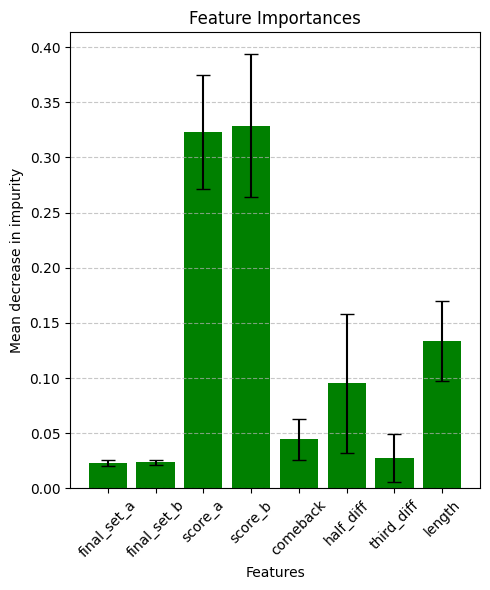

In [26]:
X = np.array((dataset[['final_set_a', 'final_set_b', 'score_a', 'score_b','comeback','half_diff','third_diff','length']].values))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Y = np.array(dataset['set_result'].values)  # Target binari

# Crea il modello di Random Forest
rf = RandomForestClassifier(random_state=42)

# Variabili per raccogliere i risultati
feature_importances = []

rf.fit(X, Y)

# Nomi delle feature
feature_names = ['final_set_a', 'final_set_b', 'score_a', 'score_b','comeback','half_diff','third_diff','length']


# Estrai le feature importance per ogni albero
tree_importances = np.array([tree.feature_importances_ for tree in rf.estimators_])

# Calcola la media e la deviazione standard per ogni feature
mean_importances = tree_importances.mean(axis=0)
std_importances = tree_importances.std(axis=0)

plt.figure(figsize=(5, 6))
plt.bar(feature_names, mean_importances, yerr=std_importances, color="green", alpha=1, capsize=5)
plt.title("Feature Importances")
plt.ylabel("Mean decrease in impurity")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Questo comportamento del modello potrebbe essere dovuto all'eccessiva importance delle feature score_a e score_b che non consentono di dare sufficiente generalizzazione per le altre feature

In [ ]:
joblib.dump(log_reg, 'LogReg.pkl')

['LogReg.pkl']

### LSTM

 **LSTM** (Long Short-Term Memory), un tipo di rete neurale ricorrente è il modello che abbiamo deciso di utilizzare per effettuare previsioni sulle vittorie del set o meno.
 - LSTM può imparare come i punteggi cambiano in **base alle azioni precedenti**, ovvero, consentono di prevedere il risultato finale della partita basato **sull'andamento dei punteggi** (rimonta o stallo) durante il set.
 - Le variabili "is_final", "final_set", "opponent_final_set", permettono di integrare queste variabili temporali in modo che il modello non solo predica un punteggio finale, ma può anche tener conto di eventi come **"l'ultimo set"** o **"l'avversario in difficoltà"**.

 E' possibile migliorare questo modello per facilitarlo successivamente

In [13]:
# Carica i dati dal dataset (presumibilmente già caricati come training_set)
player_points = np.array(dataset['points_progression'].values)
set_result = np.array(dataset['set_result'].values)
global_features = np.array(dataset[['final_set_a','final_set_b']])

# Converti ogni stringa in una lista di interi
player_points_converted = [eval(seq) if isinstance(seq, str) else seq for seq in player_points]

# Padding delle sequenze
max_sequence_length = 18  # Impostato come precedentemente
player_points_padded = pad_sequences(player_points_converted , maxlen=max_sequence_length, padding='post', truncating='post', value=-1)


X_train_seq = player_points_padded
X_train_global = global_features
Y_train = set_result

In [139]:
# Creazione del set di training

# Carica i dati dal dataset
player_points = np.array(training_set['points_progression'].values)
set_result = np.array(training_set['set_result'].values)
global_features = np.array(training_set[['final_set_a','final_set_b']])


# Padding
player_points_converted = [eval(seq) if isinstance(seq, str) else seq for seq in player_points]
player_points_padded = pad_sequences(player_points_converted , maxlen=18, padding='post', truncating='post', value=-1)


X_train_seq = player_points_padded
X_train_global = global_features
Y_train = set_result

In [32]:
# Carica i dati dal dataset di test
player_points_test = np.array(test_set['points_progression'].values)
set_result_test = np.array(test_set['set_result'].values)
global_features_test = np.array(test_set[['final_set_a', 'final_set_b']])

# Padding delle sequenze di test
player_points_converted_test = [eval(seq) if isinstance(seq, str) else seq for seq in player_points_test]
player_points_padded_test = pad_sequences(player_points_converted_test, maxlen=18, padding='post', truncating='post', value=-1)

X_test_seq = player_points_padded_test
X_test_global = global_features_test
Y_test = set_result_test

In [28]:
'''
Testare il modello LSTM e vedere se è possibile migliorare gli iperparametri
'''

# Preparazione dei dati per l'input del modello

# Input per sequenze
sequence_input = Input(shape=(18,), name='sequence_input')

# Embedding per valori diversi dal padding
x = Embedding(input_dim=3, output_dim=32)(sequence_input)

# Primo strato LSTM con 64 unità, che restituisce l'intera sequenza.
x = LSTM(64, return_sequences=True)(x)

# Secondo strato LSTM con 32 unità, che restituisce solo l'ultimo stato.
x = LSTM(32, return_sequences=False)(x)

# Input per feature globali
global_input = Input(shape=(2,), name='global_input')
global_dense = Dense(16, activation='relu')(global_input)

# Combina i due input
combined = concatenate([x, global_dense])

# Aggiungi Dropout per ridurre l'overfitting
x = Dropout(0.3)(combined)

# Strato denso con 32 unità per la combinazione.
x = Dense(32, activation='relu')(x)

# Output del modello con attivazione sigmoide per classificazione binaria
output = Dense(1, activation='sigmoid')(x)

# Costruisci il modello
lstm_model = Model(inputs=[sequence_input, global_input], outputs=output)

# Compila il modello
lstm_model.compile(optimizer='adam', loss='binary_crossentropy')

# Allenamento del modello LSTM(Provare anche con 20 epoche)
history_lstm = lstm_model.fit([X_train_seq, X_train_global], Y_train, epochs=10, batch_size=64)

Epoch 1/10
15291/15291 ━━━━━━━━━━━━━━━━━━━━ 422s 27ms/step - loss: 0.5773
Epoch 2/10
15291/15291 ━━━━━━━━━━━━━━━━━━━━ 492s 32ms/step - loss: 0.5695
Epoch 3/10
15291/15291 ━━━━━━━━━━━━━━━━━━━━ 398s 26ms/step - loss: 0.5681
Epoch 4/10
15291/15291 ━━━━━━━━━━━━━━━━━━━━ 471s 31ms/step - loss: 0.5679
Epoch 5/10
15291/15291 ━━━━━━━━━━━━━━━━━━━━ 498s 31ms/step - loss: 0.5669
Epoch 6/10
15291/15291 ━━━━━━━━━━━━━━━━━━━━ 439s 29ms/step - loss: 0.5663
Epoch 7/10
15291/15291 ━━━━━━━━━━━━━━━━━━━━ 404s 26ms/step - loss: 0.5652
Epoch 8/10
15291/15291 ━━━━━━━━━━━━━━━━━━━━ 504s 30ms/step - loss: 0.5639
Epoch 9/10
15291/15291 ━━━━━━━━━━━━━━━━━━━━ 501s 30ms/step - loss: 0.5628
Epoch 10/10
15291/15291 ━━━━━━━━━━━━━━━━━━━━ 479s 29ms/step - loss: 0.5613


In [33]:
# Previsioni probabilistiche per il set di test
y_pred_prob = lstm_model.predict([X_test_seq, X_test_global])

# Calcolare il Log Loss
log_loss_value = log_loss(Y_test, y_pred_prob)

# Calcolare il Brier Score
brier_score_value = brier_score_loss(Y_test, y_pred_prob)

# Stampa dei risultati
print(f"Log Loss: {log_loss_value:.4f}")
print(f"Brier Score: {brier_score_value:.4f}")

6118/6118 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step
Log Loss: 0.5609
Brier Score: 0.1896


In [147]:
'''
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0],  # 5-5 combattuta
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],  # 5-5 rimonta mia
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # 5-5 rimonta sua
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],  # 6-5 combattuta
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # 6-5 rimonta mia
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # 6-5 rimonta sua
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 9-9 rimonta sua
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 9-9 rimonta mia
    [0, 1, 0, 0, 1, 0, 1, 0, 0, 1],  # 4-6 combattuta
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # 4-6 rimonta sua
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],  # 4-6 rimonta mia
'''

# Esempi delle sequenze di test
test_examples = [
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],  # 6-5 combattuta
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # 6-5 rimonta mia
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # 6-5 rimonta sua
]

global_features_example = [[0, 0] for seq in test_examples]
X_global = np.array(global_features_example)
# Trasforma le sequenze di test (applica eventuali trasformazioni come normalizzazione, encoding, ecc.)

# Padding delle sequenze di test
X_seq = pad_sequences(test_examples, maxlen=18, padding='post', truncating='post', value=-1)

# Prevedi le probabilità usando il modello LSTM
y_pred_prob_new = lstm_model.predict([X_seq, X_global])

# Converte le probabilità in etichette binarie
y_pred_new = (y_pred_prob_new > 0.5).astype(int)

# Stampa le previsioni per ciascun esempio
for i, example in enumerate(test_examples):
    print(f"Esempio {i+1}: {example}")
    print(f"Probabilità previste: {y_pred_prob_new[i][0]:.4f}")
    print(f"Predizione (classe): {y_pred_new[i][0]}")
    print("-" * 50)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Esempio 1: [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]
Probabilità previste: 0.6435
Predizione (classe): 1
--------------------------------------------------
Esempio 2: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Probabilità previste: 0.6446
Predizione (classe): 1
--------------------------------------------------
Esempio 3: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Probabilità previste: 0.6313
Predizione (classe): 1
--------------------------------------------------


In [30]:
lstm_model.save('LSTM1.keras')

### Logistic Regression vs LSTM

In [7]:
lstm_model = tf.keras.models.load_model('LSTM.keras')

In [11]:
import itertools

def transform_sequences(seq):

    new_seq=[]

    # Aggiungo 'final_set_a'
    new_seq.append(0)
    # Aggiungo 'final_set_b'
    new_seq.append(0)
    punti_a = punti_b = rimonta_a = rimonta_b = 0

    for point in seq:
        if point == 1:
            rimonta_a += 1
            rimonta_b = 0
            punti_a += 1
        elif point == 0:
            rimonta_b += 1
            rimonta_a = 0
            punti_b += 1


    # Aggiungo 'score_a'
    new_seq.append(punti_a)

    # Aggiungo 'score_b'
    new_seq.append(punti_b)


    # Aggiungo 'comeback'
    if rimonta_a > rimonta_b:
        new_seq.append(rimonta_a / punti_a)
    else:
        new_seq.append(-rimonta_b / punti_b)



    punti_a = punti_b = 0
    start_index = len(seq) // 2

    for point in seq[start_index:]:
        if point == 1:
            punti_a += 1
        elif point == 0:
            punti_b += 1

    # Aggiungo 'half_diff'
    new_seq.append(punti_a - punti_b)


    punti_a = punti_b = 0
    start_index = 2*(len(seq) // 3)+1

    for point in seq[start_index:]:
        if point == 1:
            punti_a += 1
        elif point == 0:
            punti_b += 1

    # Aggiungo 'third_diff'
    new_seq.append(punti_a - punti_b)

    # Aggiungo 'length'
    new_seq.append(len(seq))

    return new_seq



def genera_vettori(log_reg, lstm_model, features, n_top=5):

    base = [1] * 6 + [0] * 5

    # Otteniamo tutte le permutazioni uniche del vettore base
    permutazioni = set(itertools.permutations(base))


    log_reg_predictions = []
    lstm_predictions = []

    print(len(permutazioni))

    # Iteriamo su tutte le permutazioni uniche
    for vettore in permutazioni:

        sequenza = list(vettore)


        ##### Logistic Regression ######
        X_log_reg = np.array(transform_sequences(sequenza))
        X_log_reg = X_log_reg.reshape(1, -1)
        X_log_reg = scaler_log_reg.transform(X_log_reg)

        y_pred_log_reg = log_reg.predict_proba(X_log_reg)[:, 1]


        ##### LSTM ######
        X_lstm = np.array([sequenza])
        X_lstm = pad_sequences(X_lstm, maxlen=18, padding='post', truncating='post', value=-1)

        y_pred_prob = lstm_model.predict([X_lstm, features], verbose=0)


        # Memorizziamo le predizioni e probabilità
        log_reg_predictions.append((sequenza, y_pred_log_reg))
        lstm_predictions.append((sequenza, y_pred_prob[0]))



    # Ordinamento delle predizioni per probabilità decrescente (top N)
    lstm_predictions_sorted = sorted(lstm_predictions, key=lambda x: x[1], reverse=True)[:n_top]
    log_reg_predictions_sorted = sorted(log_reg_predictions, key=lambda x: x[1], reverse=True)[:n_top]

    # Ordinamento delle predizioni per probabilità crescente (bottom N)
    lstm_predictions_sorted_bottom = sorted(lstm_predictions, key=lambda x: x[1])[:n_top]
    log_reg_predictions_sorted_bottom = sorted(log_reg_predictions, key=lambda x: x[1])[:n_top]



    print(f"\nTop {n_top} predizioni per Log Reg (Probabilità più alta):")
    for i, (sequenza, prob) in enumerate(log_reg_predictions_sorted):
        print(f"{i+1}: Sequenza: {sequenza}, Probabilità: {prob}")

    print(f"Top {n_top} predizioni per LSTM (Probabilità più alta):")
    for i, (sequenza, prob) in enumerate(lstm_predictions_sorted):
        print(f"{i+1}: Sequenza: {sequenza}, Probabilità: {prob}")

    print(f"\nBottom {n_top} predizioni per Log Reg (Probabilità più bassa):")
    for i, (sequenza, prob) in enumerate(log_reg_predictions_sorted_bottom):
        print(f"{i+1}: Sequenza: {sequenza}, Probabilità: {prob}")

    print(f"\nBottom {n_top} predizioni per LSTM (Probabilità più bassa):")
    for i, (sequenza, prob) in enumerate(lstm_predictions_sorted_bottom):
        print(f"{i+1}: Sequenza: {sequenza}, Probabilità: {prob}")



features = np.array([[0, 0]])


genera_vettori(log_reg, lstm_model, features)

462

Top 5 predizioni per Log Reg (Probabilità più alta):
1: Sequenza: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], Probabilità: [0.66456541]
2: Sequenza: [1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0], Probabilità: [0.66174497]
3: Sequenza: [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], Probabilità: [0.66083418]
4: Sequenza: [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0], Probabilità: [0.66083418]
5: Sequenza: [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0], Probabilità: [0.66083418]
Top 5 predizioni per LSTM (Probabilità più alta):
1: Sequenza: [0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1], Probabilità: [0.6857944]
2: Sequenza: [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1], Probabilità: [0.67621964]
3: Sequenza: [1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1], Probabilità: [0.6716774]
4: Sequenza: [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1], Probabilità: [0.6709122]
5: Sequenza: [0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0], Probabilità: [0.6702301]

Bottom 5 predizioni per Log Reg (Probabilità più bassa):
1: Sequenza: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], Probabilità: [0.62937373]
2: Sequenza: [0, 1, 0, 0

In [156]:
def testing_personalizzato(cartella_test, modelli, max_sequence_length):

    risultati = []

    for file_name in os.listdir(cartella_test):
        if file_name.endswith(".csv"):
            percorso_file = os.path.join(cartella_test, file_name)
            dataset_test = pd.read_csv(percorso_file)

            Y_test = dataset_test['set_result'].values

            for modello in modelli:


                if modello == lstm_model:

                    player_points_test = dataset_test['points_progression'].values
                    global_features_test = dataset_test[['final_set_a', 'final_set_b']].values

                    player_points_converted_test = [
                        eval(seq) if isinstance(seq, str) else seq for seq in player_points_test
                    ]

                    X_test_seq = pad_sequences(
                        player_points_converted_test,
                        maxlen=max_sequence_length,
                        padding='post',
                        truncating='post',
                        value=-1
                    )
                    X_test_global = global_features_test

                    y_pred = modello.predict([X_test_seq, X_test_global], verbose=0).flatten()


                else:

                    columns = ['final_set_a', 'final_set_b', 'score_a', 'score_b', 'comeback', 'half_diff','third_diff', 'length']
                    X_test = dataset_test[columns].values

                    if scaler is not None:
                        X_test = scaler.transform(X_test)

                    y_pred = modello.predict_proba(X_test)[:, 1]


                log_loss_value = log_loss(Y_test, y_pred)
                brier_score_value = brier_score_loss(Y_test, y_pred)

                risultati.append({
                    'file': file_name,
                    'modello': modello.name if hasattr(modello, 'name') else str(modello),
                    'log_loss': log_loss_value,
                    'brier_score': brier_score_value
                })

    return risultati



def stampa_risultati_confronto(risultati):
    for risultato in risultati:
        print(f"File: {risultato['file'][:3]}")
        print(f"Modello: {risultato['modello']}")
        print(f"Log Loss: {risultato['log_loss']:.4f}")
        print(f"Brier Score: {risultato['brier_score']:.4f}")
        print("-" * 50)



cartella_test = "dataset_test"
modelli = [log_reg, lstm_model]


risultati_test = testing_personalizzato(cartella_test, modelli, 18)

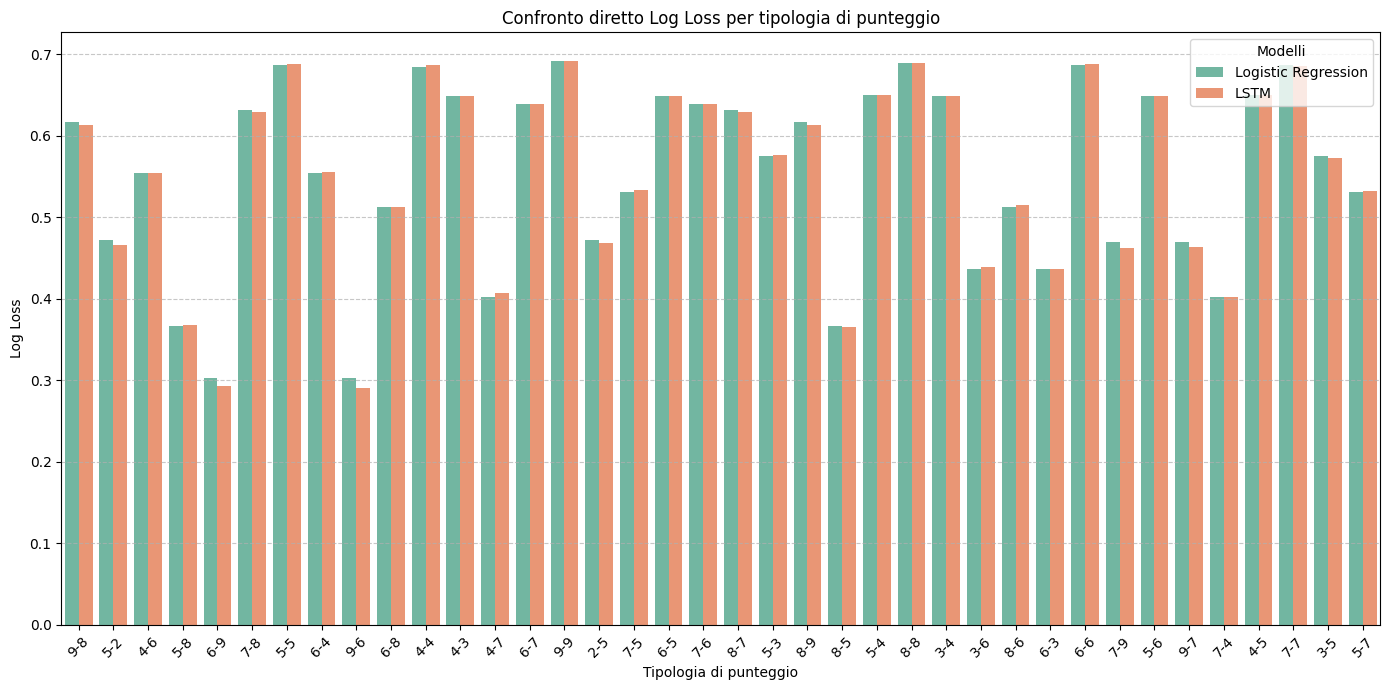

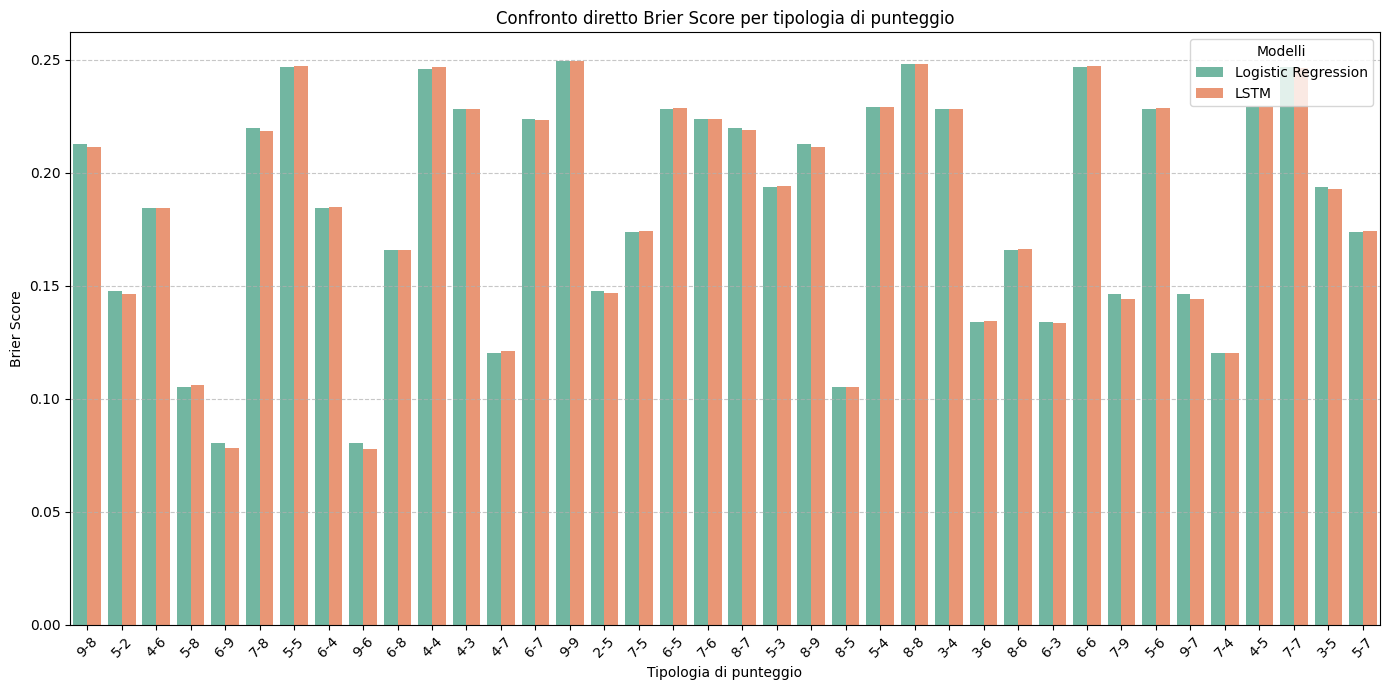

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def grafico_confronto_metriche(risultati):
    """
    Confronta le prestazioni di Logistic Regression e LSTM sui punteggi con un grafico a barre per Log Loss e Brier Score.

    Parametri:
        risultati (list of dict): Lista di risultati con 'file', 'modello', 'log_loss', 'brier_score'.
    """
    # Converti i risultati in un DataFrame
    df = pd.DataFrame(risultati)
    df['punteggio'] = df['file'].str[:3]  # Estrai il punteggio dal nome del file

    # Confronto diretto per Log Loss
    plt.figure(figsize=(14, 7))
    sns.barplot(
        data=df,
        x='punteggio',
        y='log_loss',
        hue='modello',
        palette='Set2',
        errorbar='sd',  # Aggiungi l'intervallo di confidenza per la deviazione standard
        capsize=0.1  # Piccole estremità per la barra d'errore
    )
    plt.title("Confronto diretto Log Loss per tipologia di punteggio")
    plt.xlabel("Tipologia di punteggio")
    plt.ylabel("Log Loss")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Modifica della legenda
    handles, labels = plt.gca().get_legend_handles_labels()

    # Personalizzare le etichette della legenda
    # Sostituisci i nomi esistenti con quelli desiderati
    labels = ['Logistic Regression', 'LSTM']  # Esempio di nomi personalizzati

    # Personalizzare la posizione e titolo della legenda
    plt.legend(handles, labels, title="Modelli", loc='upper right', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

    # Confronto diretto per Brier Score
    plt.figure(figsize=(14, 7))
    sns.barplot(
        data=df,
        x='punteggio',
        y='brier_score',
        hue='modello',
        palette='Set2',
        errorbar='sd',  # Aggiungi l'intervallo di confidenza per la deviazione standard
        capsize=0.1  # Piccole estremità per la barra d'errore
    )
    plt.title("Confronto diretto Brier Score per tipologia di punteggio")
    plt.xlabel("Tipologia di punteggio")
    plt.ylabel("Brier Score")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Modifica della legenda
    handles, labels = plt.gca().get_legend_handles_labels()

    # Personalizzare le etichette della legenda
    # Sostituisci i nomi esistenti con quelli desiderati
    labels = ['Logistic Regression', 'LSTM']  # Esempio di nomi personalizzati

    # Personalizzare la posizione e titolo della legenda
    plt.legend(handles, labels, title="Modelli", loc='upper right', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

grafico_confronto_metriche(risultati_test)


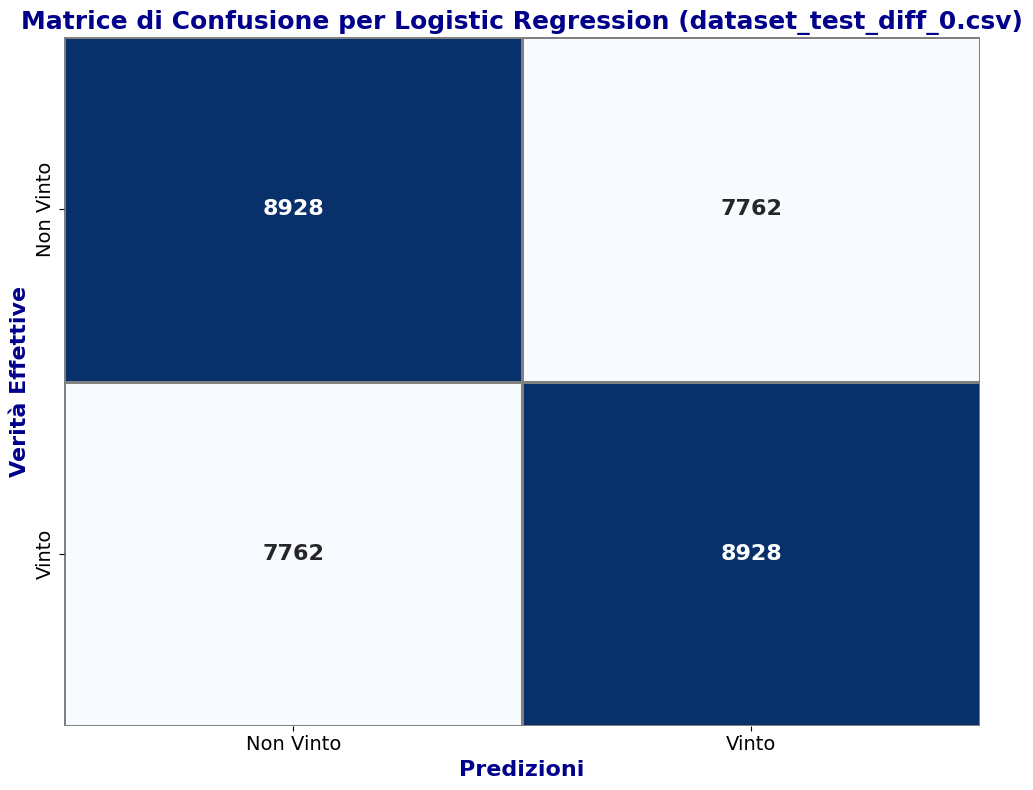

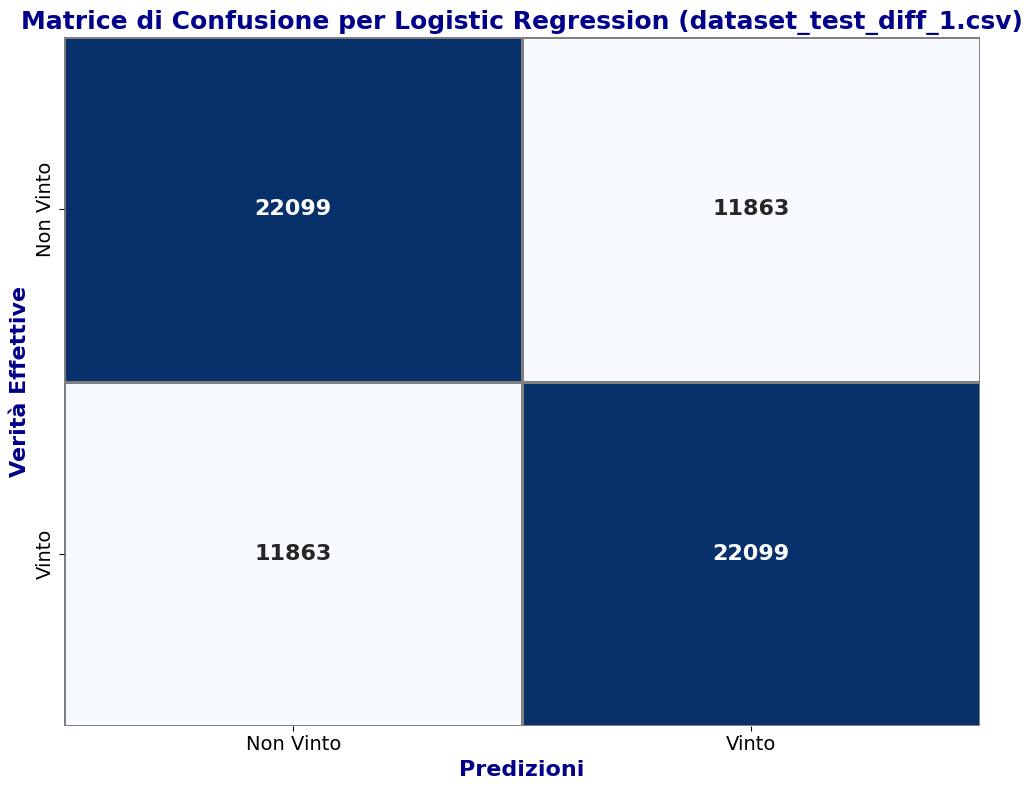

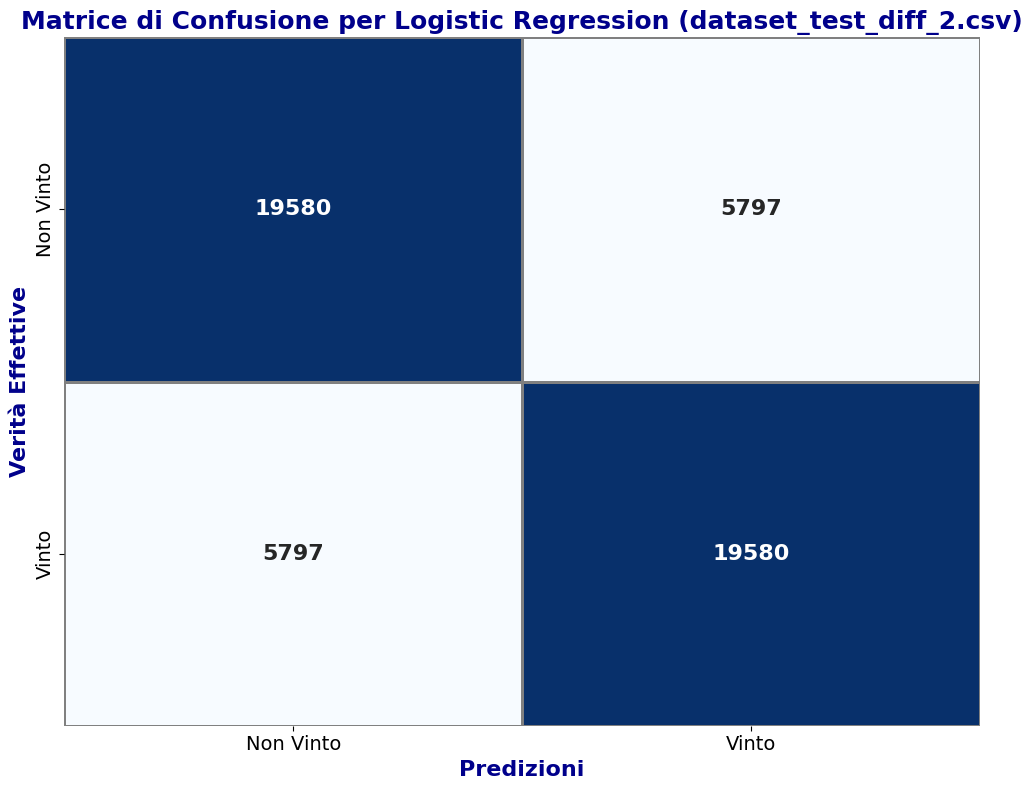

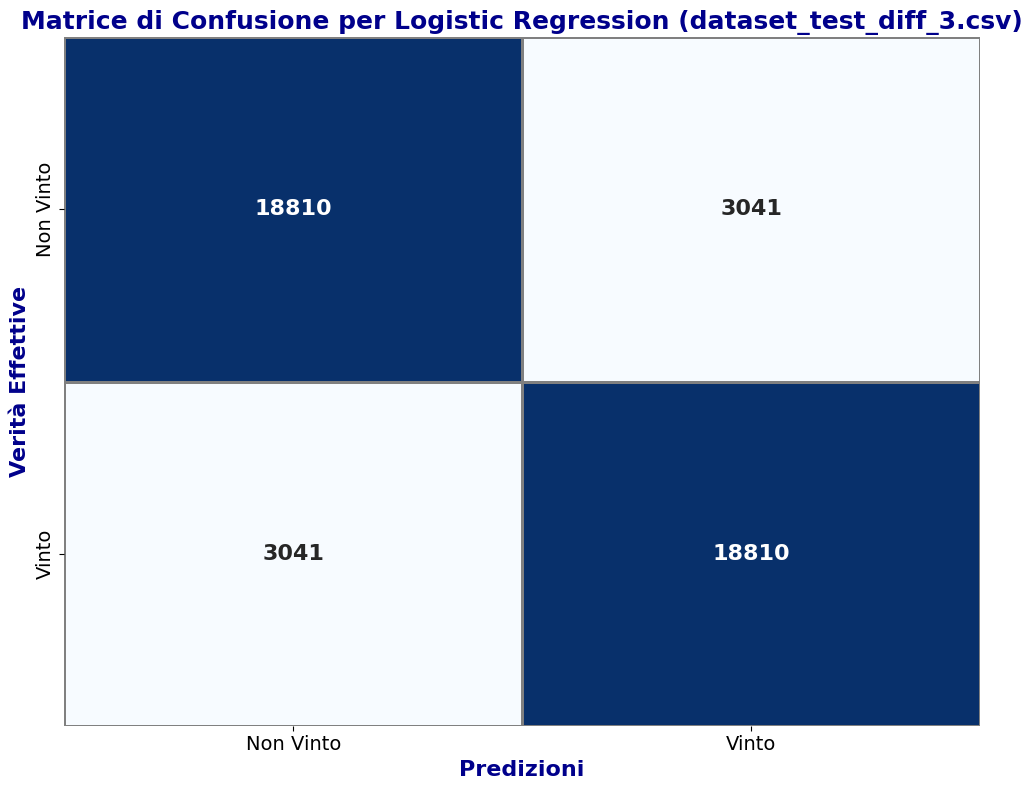

In [27]:

# Funzione per generare e visualizzare la matrice di confusione per Logistic Regression
def plot_confusion_matrix_logreg(dataset_file, log_reg, scaler_log_reg, cartella_test):
    percorso_file = os.path.join(cartella_test, dataset_file)
    dataset_test = pd.read_csv(percorso_file)

    Y_test = dataset_test['set_result'].values

    # Carico le colonne specifiche
    columns = ['final_set_a', 'final_set_b', 'score_a', 'score_b', 'comeback', 'half_diff', 'third_diff', 'length']
    X_test = dataset_test[columns].values

    # Se il dataset è stato scalato, applico la trasformazione
    if scaler_log_reg is not None:
        X_test = scaler_log_reg.transform(X_test)

    # Predizioni con il modello di regressione logistica
    y_pred_logreg = log_reg.predict_proba(X_test)[:, 1]

    # Convertiamo le probabilità in predizioni binarie
    Y_pred_binary = (y_pred_logreg > 0.5).astype(int)

    # Confusion Matrix e Percentuali
    cm_logreg = confusion_matrix(Y_test, Y_pred_binary)
    cm_percentage_logreg = cm_logreg.astype('float') / cm_logreg.sum(axis=1)[:, np.newaxis] * 100

    # Creazione della figura
    plt.figure(figsize=(10, 8))

    # Heatmap della Confusion Matrix
    sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'],
                linewidths=1, linecolor='gray', annot_kws={'size': 16, 'weight': 'bold'},
                cbar_kws={"shrink": 0.8})

    # Titolo e etichette degli assi
    plt.title(f'Matrice di Confusione per Logistic Regression ({dataset_file})', fontsize=18, weight='bold', color='darkblue')
    plt.xlabel('Predizioni', fontsize=16, weight='bold', color='darkblue')
    plt.ylabel('Verità Effettive', fontsize=16, weight='bold', color='darkblue')

    # Gestire la griglia e migliorare la leggibilità
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Aggiungere spazio tra il titolo e la heatmap
    plt.tight_layout()

    # Mostrare la heatmap
    plt.show()

# Cartella di lavoro
cartella_test = "dataset_test_diff"

# Lista dei file CSV da processare
file_list = [
    "dataset_test_diff_0.csv",
    "dataset_test_diff_1.csv",
    "dataset_test_diff_2.csv",
    "dataset_test_diff_3.csv"  # Assumendo che tu abbia una quarta versione
]

# Ciclo sui file per generare i grafici
for file in file_list:
    plot_confusion_matrix_logreg(file, log_reg, scaler_log_reg, cartella_test)

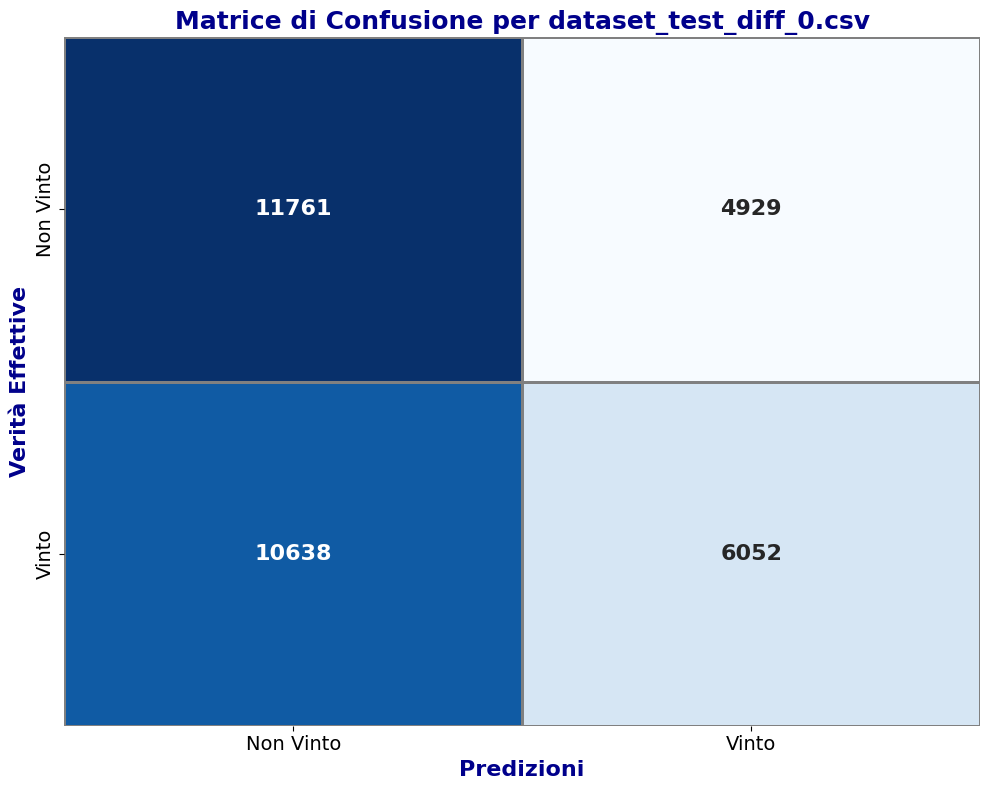

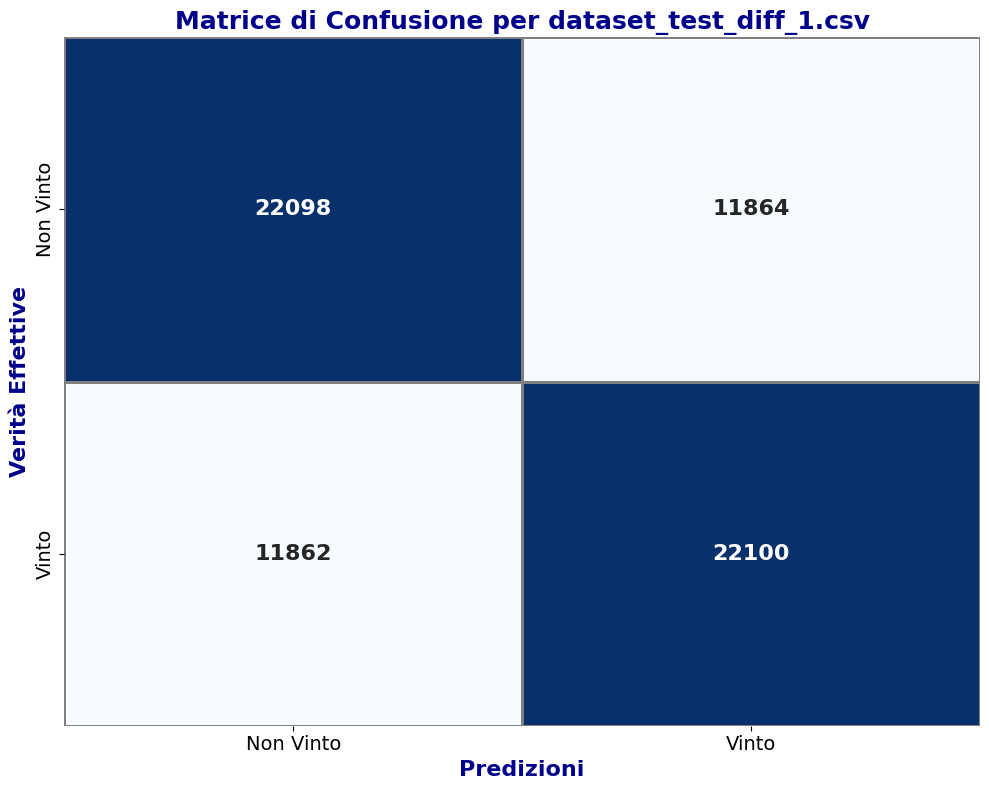

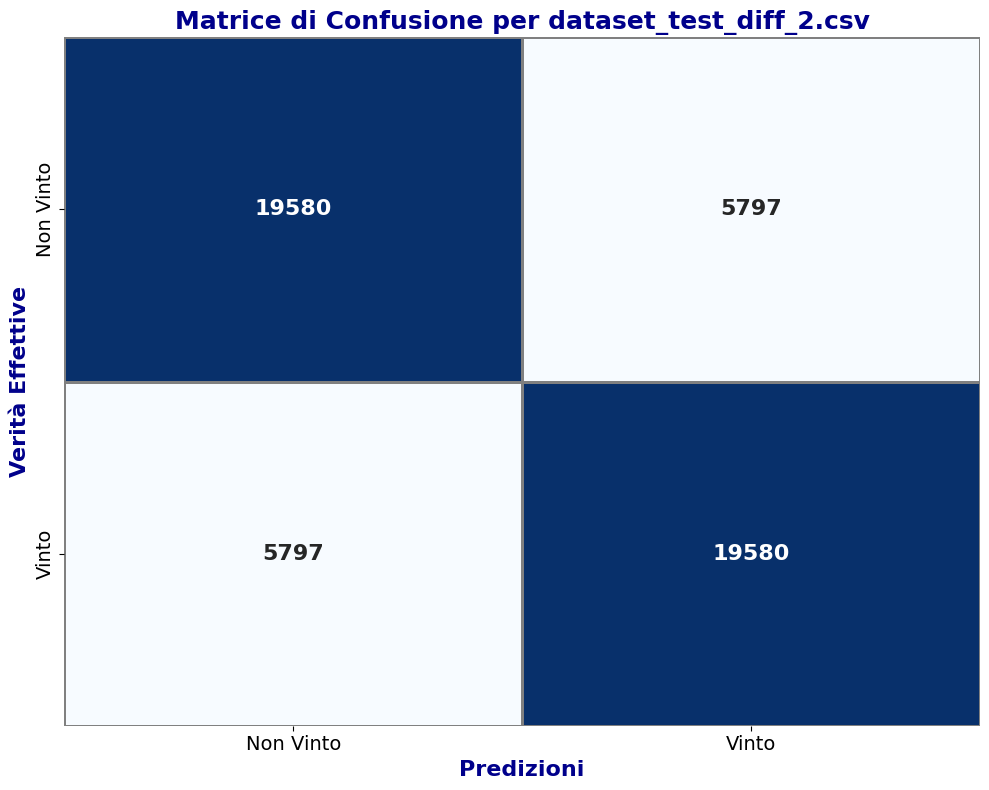

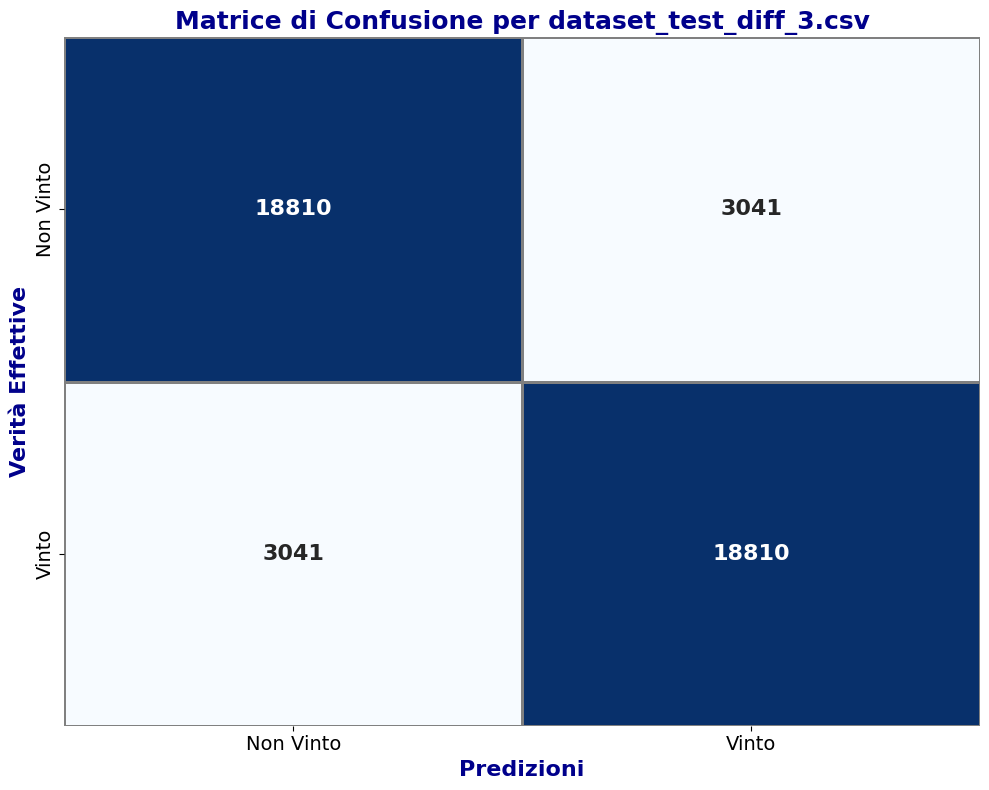

In [26]:
# Funzione per generare e visualizzare la matrice di confusione
def plot_confusion_matrix(dataset_file, lstm_model, cartella_test):
    percorso_file = os.path.join(cartella_test, dataset_file)
    dataset_test = pd.read_csv(percorso_file)

    Y_test = dataset_test['set_result'].values
    player_points_test = dataset_test['points_progression'].values
    global_features_test = dataset_test[['final_set_a', 'final_set_b']].values

    # Conversione dei dati in sequenze
    player_points_converted_test = [
        eval(seq) if isinstance(seq, str) else seq for seq in player_points_test
    ]

    # Padding delle sequenze
    X_test_seq = pad_sequences(
        player_points_converted_test,
        maxlen=18,
        padding='post',
        truncating='post',
        value=-1
    )
    X_test_global = global_features_test

    # Predizioni del modello LSTM
    y_pred = lstm_model.predict([X_test_seq, X_test_global], verbose=0).flatten()
    Y_pred_binary = (y_pred > 0.5).astype(int)

    # Calcolo della Confusion Matrix e delle percentuali
    cm = confusion_matrix(Y_test, Y_pred_binary)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Creazione della figura
    plt.figure(figsize=(10, 8))

    # Heatmap della Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'],
                linewidths=1, linecolor='gray', annot_kws={'size': 16, 'weight': 'bold'},
                cbar_kws={"shrink": 0.8})

    # Titolo e etichette degli assi
    plt.title(f'Matrice di Confusione per {dataset_file}', fontsize=18, weight='bold', color='darkblue')
    plt.xlabel('Predizioni', fontsize=16, weight='bold', color='darkblue')
    plt.ylabel('Verità Effettive', fontsize=16, weight='bold', color='darkblue')

    # Gestire la griglia e migliorare la leggibilità
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Aggiungere spazio tra il titolo e la heatmap
    plt.tight_layout()

    # Mostrare la heatmap
    plt.show()

# Cartella di lavoro
cartella_test = "dataset_test_diff"

# Lista dei file CSV da processare
file_list = [
    "dataset_test_diff_0.csv",
    "dataset_test_diff_1.csv",
    "dataset_test_diff_2.csv",
    "dataset_test_diff_3.csv"  # Assumendo che tu abbia una quarta versione
]

# Ciclo sui file per generare i grafici
for file in file_list:
    plot_confusion_matrix(file, lstm_model, cartella_test)

### Funzione matematica

In [ ]:
#Funzione che calcola matematicamente la probabilità di vittoria del set

from math import comb

def prob(p, x, y):
    # Somma della prima parte
    sum_part1 = 0
    for i in range(0, 10 - y):
        sum_part1 += p**(11 - x) * math.comb(10 + i - x, i) * (1 - p)**i

    # Seconda parte della formula
    part2 = p**(10 - x) * math.comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)
    part2 *= (p**2) / (1 - 2 * p * (1 - p))

    # Somma totale
    total = sum_part1 + part2
    return total

# Esempio di uso
p = 0.5  # Probabilità di vincere un punto
x = 0    # Punti già vinti dal giocatore
y = 0    # Punti già vinti dall'avversario

result = prob(p, x, y)
print("Probabilità:", result)

Probabilità: 0.5


In [ ]:
#Probabilità di arrivare 10-10

def prob(p, x, y):

    total = p**(10 - x) * math.comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)

    return total

# Esempio di uso
p = 0.5  # Probabilità di vincere un punto
x = 6    # Punti già vinti dal giocatore
y = 6    # Punti già vinti dall'avversario

result = prob(p, x, y)
print("Probabilità:", result)

Probabilità: 0.2734375


In [ ]:
from math import comb

def prob(p, x, y):
    # Somma della prima parte
    sum_part1 = 0
    for i in range(0, 10 - y):
        sum_part1 += p**(11 - x) * comb(10 + i - x, i) * (1 - p)**i

    # Seconda parte della formula
    part2 = p**(10 - x) * comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)
    part2 *= (p**2) / (1 - 2 * p * (1 - p))

    # Somma totale
    total = sum_part1 + part2
    return total

# Probabilità di vincere un punto
p = 0.5

# Lista per raccogliere i risultati
results = []

# Calcoliamo la probabilità per tutte le combinazioni di x e y con x <= 10 e y <= 10
for x in range(0, 11):  # x va da 0 a 10
    for y in range(0, 11):  # y va da 0 a 10
        if x + y >= 7:  # Condizione che x + y deve essere maggiore o uguale a 7
            result = prob(p, x, y)
            if 0.1 < result < 0.9:  # La probabilità deve essere compresa tra 0.1 e 0.9
                results.append((x, y, result))

# Ordinare i risultati in base alla probabilità
results.sort(key=lambda x: x[2])  # Ordinamento in base al terzo elemento (probabilità)

# Stampare i risultati ordinati
for x, y, result in results:
    print(f"Probabilità per x={x}, y={y}: {result}")


Probabilità per x=6, y=9: 0.109375
Probabilità per x=3, y=7: 0.11328125
Probabilità per x=8, y=10: 0.125
Probabilità per x=2, y=6: 0.1334228515625
Probabilità per x=5, y=8: 0.14453125
Probabilità per x=4, y=7: 0.171875
Probabilità per x=7, y=9: 0.1875
Probabilità per x=3, y=6: 0.19384765625
Probabilità per x=2, y=5: 0.21197509765625
Probabilità per x=6, y=8: 0.2265625
Probabilità per x=9, y=10: 0.25
Probabilità per x=5, y=7: 0.25390625
Probabilità per x=4, y=6: 0.2744140625
Probabilità per x=3, y=5: 0.29052734375
Probabilità per x=8, y=9: 0.3125
Probabilità per x=7, y=8: 0.34375
Probabilità per x=6, y=7: 0.36328125
Probabilità per x=5, y=6: 0.376953125
Probabilità per x=4, y=5: 0.38720703125
Probabilità per x=3, y=4: 0.395263671875
Probabilità per x=4, y=4: 0.5
Probabilità per x=5, y=5: 0.5
Probabilità per x=6, y=6: 0.5
Probabilità per x=7, y=7: 0.5
Probabilità per x=8, y=8: 0.5
Probabilità per x=9, y=9: 0.5
Probabilità per x=10, y=10: 0.5
Probabilità per x=4, y=3: 0.604736328125
Proba